# Integration tests for interleaved filter/smoother

[Durbin and Koopman (2000)](http://onlinelibrary.wiley.com/doi/10.1111/1467-9892.00186/abstract) and Durbin and Koopman (2012) section 6.4 showed that a method of interleaving vector observations to create a univariate series avoided matrix inversion and resulted in a large computational speedup.

**Important**: This method assumes that $\varepsilon_t \sim \mathcal{N}(0, H_t)$ with $H_t$ diagonal!

In [17]:
using Distributions
using PyPlot
plt.style[:use]("ggplot")

srand(12347) # set random seed

# Generate data from a state space model

**Note**: Observation noise is deliberately set low here so that recovered states line up *exactly* below (i.e., it's a sanity check).

In [18]:
Z = [1 -1. ; 0 1 ; 1 0]  # observation matrix
H = 0.005 * [1 0 0 ; 0 1.2 0 ; 0 0 1.5]

Np, Nm = size(Z)

th = 10 * pi / 180  # rotation angle
T = [cos(th) sin(th) ; -sin(th) cos(th)]
R = reshape([1.1 1], 2, 1)
Q = reshape([0.25], 1, 1)

Nr = size(R, 2)

a_init = zeros(Nm)
P_init = 5 * eye(Nm)


2x2 Array{Float64,2}:
 5.0  0.0
 0.0  5.0

## Now generate some data

In [19]:
Nt = 100  # number of samples

100

In [20]:
# preallocate data arrays
α = Array(Float64, Nm, Nt)
y = Array(Float64, Np, Nt)
ϵ = Array(Float64, Np, Nt)
η = Array(Float64, Nr, Nt)

1x100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [21]:
# initialize

α[:, 1] = rand(MvNormal(a_init, P_init))

for t in 1:Nt
    ϵ[:, t] = rand(MvNormal(H))
    η[:, t] = rand(MvNormal(Q))
    y[:, t] = Z * α[:, t] + ϵ[:, t]
    if t < Nt
        α[:, t + 1] = T * α[:, t] + R * η[:, t]
    end
end

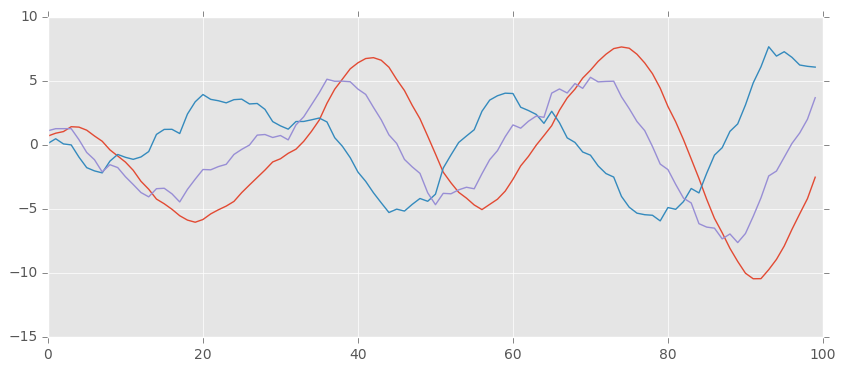

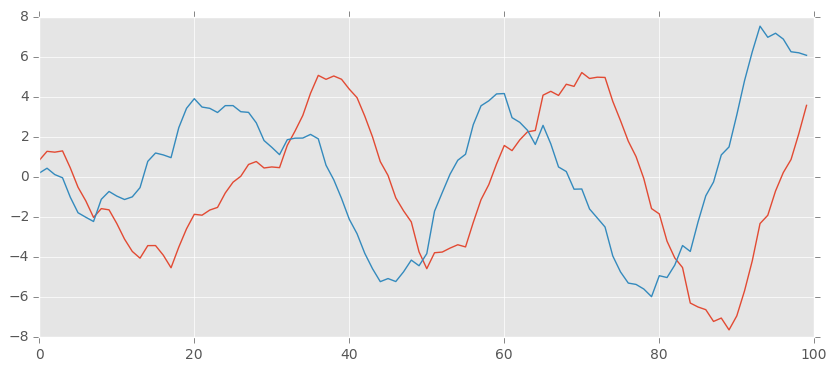

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11da1b1d0>
 PyObject <matplotlib.lines.Line2D object at 0x11da1b450>

In [22]:
figure(figsize=(10, 4))
plot(y')

figure(figsize=(10, 4))
plot(α')

# Kalman filter

In [23]:
# test for diagonality of H
# H (minus its diagonals) should be the 0 matrix
assert(H == diagm(diag(H)))

In [75]:
Np, Nt = size(y)
Nm = size(P_init, 1)

# preallocate
a = Array(Float64, Nm, Np + 1, Nt)
P = Array(Float64, Nm, Nm, Np + 1, Nt)
v = Array(Float64, Np, Nt)
F = Array(Float64, Np, Nt)
K = Array(Float64, Nm, Np, Nt);

In [119]:
# initialize
a[:, 1, 1] = a_init
P[:, :, 1, 1] = P_init

for t in 1:Nt, i in 1:Np
    z = squeeze(Z[i, :], 1)  # now a column vector
    v[i, t] = y[i, t] - dot(z, a[:, i, t])
    F[i, t] = dot(z, P[:, :, i, t] * z) + H[i, i]
    Finv = 1. / F[i, t]
    if F[i, t] != 0
        K[:, i, t] = P[:, :, i, t] * z * Finv
    else
        K[:, i, t] = 0
    end
    
    a[:, i + 1, t] = a[:, i, t] + K[:, i, t] * v[i, t]
    P[:, :, i + 1, t] = P[:, :, i, t] - F[i, t] * (K[:, i, t] * K[:, i, t]')
    
    if i == Np && t < Nt
        a[:, 1, t + 1] = T * a[:, Np + 1, t]
        P[:, :, 1, t + 1] = T * P[:, :, Np + 1] * T' + R * Q * R'
    end
end

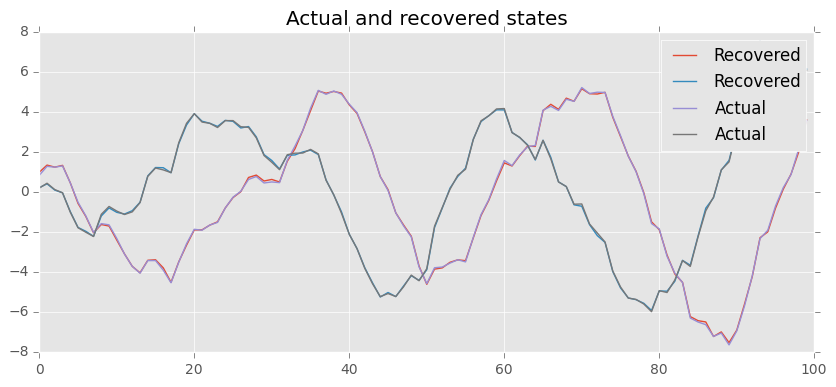

PyObject <matplotlib.legend.Legend object at 0x120076a50>

In [120]:
figure(figsize=(10, 4))
plot(squeeze(a[:, end, :], 2)', label="Recovered")
plot(α', label="Actual")
title("Actual and recovered states")
legend()

#Smoother

In [136]:
# preallocate
r = Array(Float64, Nm, Np + 1, Nt)

# initialize
r[:, end, end] = 0

for t in Nt:-1:1, i in (Np + 1):-1:2
    ii = i - 1
    L = eye(Nm) - K[:, ii, t] * Z[ii, :]
    z = squeeze(Z[ii, :], 1)  # now a column vector
    
    r[:, i - 1, t] = z * (v[ii, t] / F[ii, t]) + L' * r[:, i, t]
    
    if i == 2 && t > 1
        r[:, Np + 1, t - 1] = T' * r[:, 1, t]
    end
end

# initialize again
ahat = Array(Float64, Nm, Nt)
ahat[:, 1] = a[:, 1, 1] + P[:, :, 1, 1] * r[:, 1, 1]
RQR = R * Q * R'

for t in 1:(Nt - 1)
    ahat[:, t + 1] = T * ahat[:, t] + RQR * r[:, 1, t + 1]
end

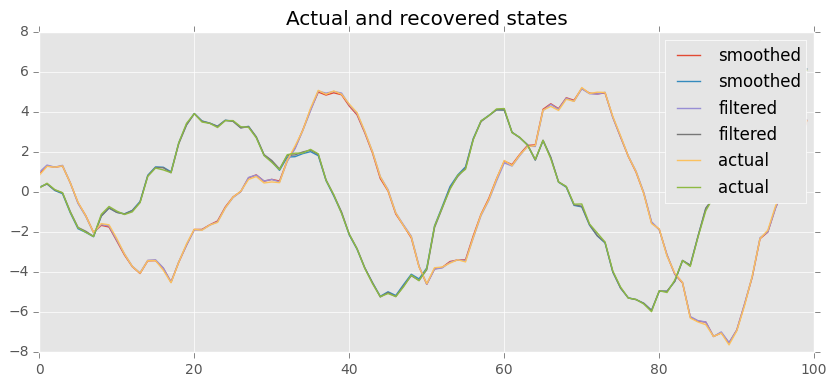

PyObject <matplotlib.legend.Legend object at 0x11db0fc50>

In [137]:
figure(figsize=(10, 4))
plot(ahat', label="smoothed")
plot(squeeze(a[:, end, :], 2)', label="filtered")
plot(α', label="actual")
title("Actual and recovered states")
legend()